# Import data and preprocessing

### Set paths based on colab or local

In [1]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if (IN_COLAB):
    drive.mount('/content/drive')
    import sys
    sys.path.append("/content/drive/My Drive/nlp2020-hw1-master/hw1/stud")
    
    train_path = "/content/drive/My Drive/nlp2020-hw1-master/data/train.tsv"
    dev_path = "/content/drive/My Drive/nlp2020-hw1-master/data/dev.tsv"
    test_path = "/content/drive/My Drive/nlp2020-hw1-master/data/test.tsv"
    
    sentences_vocabulary_path = "/content/drive/My Drive/nlp2020-hw1-master/model/sentences_vocabulary.pt"
    embedding_path = "/content/drive/My Drive/nlp2020-hw1-master/model/wiki-news-300d-1M.vec"
    embedding_layer_path = "/content/drive/My Drive/nlp2020-hw1-master/model/embedding_layer.pt"
    
    model_path = "/content/drive/My Drive/nlp2020-hw1-master/model/model.pt"
    
else:
    train_path = "../../data/train.tsv"
    dev_path = "../../data/dev.tsv"
    test_path = "../../data/test.tsv"
    
    sentences_vocabulary_path = "../../model/sentences_vocabulary.pt"
    embedding_path = "../../model/wiki-news-300d-1M.vec"
    embedding_layer_path = "../../model/embedding_layer.pt"
    
    model_path = "../../model/model.pt"

### Import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from my_model import MyModel, HParam
from tools import import_data
from preprocessing import *
from prediction import *
from train import Trainer

## Create the dataset for pytorch

### Import data: create list[list[string]]

In [3]:
train_sentences, train_labels = import_data (train_path)
dev_sentences, dev_labels = import_data (dev_path)
test_sentences, test_labels = import_data (test_path)

for i in range(3):
    print (train_sentences[i])
    print (train_labels[i])

['Burgdorf', 'had', 'brought', 'a', 'capsule', 'of', 'cyanide', 'for', 'the', 'occasion', '.']
['PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Terry', 'Daniher', 'and', 'his', 'brother', 'Neale', 'would', 'come', 'via', 'a', 'trade', 'with', 'South', 'Melbourne', ',', 'and', 'Roger', 'Merrett', 'joined', 'soon', 'afterwards', 'to', 'form', 'the', 'nucleus', 'of', 'what', 'would', 'become', 'the', 'formidable', 'Essendon', 'sides', 'of', 'the', '1980s', '.']
['PER', 'PER', 'O', 'O', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'O', 'PER', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O']
['But', 'her', 'remarks', 'about', 'Eugene', 'were', 'made', 'years', 'later', ',', 'and', 'only', 'then', 'after', 'he', 'had', 'severely', 'mauled', 'the', 'armies', 'of', 'her', 'brother-in-law', ',', 'Louis', 'XIV', '.']
['O', 'O', 'O', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

### Create windows 

In [4]:
windows_sentences_train = create_windows(train_sentences, HParam.window_size, HParam.window_shift)
windows_labels_train = create_windows(train_labels, HParam.window_size, HParam.window_shift)
windows_sentences_dev = create_windows(dev_sentences, HParam.window_size, HParam.window_shift)
windows_labels_dev = create_windows(dev_labels, HParam.window_size, HParam.window_shift)

### Create vocabularies

In [5]:
sentences_vocabulary = create_vocabulary(train_sentences)
torch.save(sentences_vocabulary, sentences_vocabulary_path)

In [8]:
labels_vocabulary = create_labels_vocabulary()

print (labels_vocabulary)

{'PER': 0.0, 'LOC': 1.0, 'ORG': 2.0, 'O': 3.0, None: 4.0}


### Load or generate a new embedding layer from pretrained embeddings

In [6]:
embedding_layer = torch.load(embedding_layer_path)

#embedding_matrix = create_embedding(embedding_path, sentences_vocabulary, HParam.embedding_size)
#embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, HParam.freeze)

### Encode sentences and labels in windows

In [9]:
train_sentences_enc = encode_sentences_in_windows(windows_sentences_train, sentences_vocabulary)
dev_sentences_enc = encode_sentences_in_windows(windows_sentences_dev, sentences_vocabulary)

In [10]:
train_labels_enc = encode_labels_in_windows(windows_labels_train, labels_vocabulary)
dev_labels_enc = encode_labels_in_windows(windows_labels_dev, labels_vocabulary)

### Create train and dev dataset

In [11]:
train_dataset = DataLoader(NERDataset(train_sentences_enc, train_labels_enc, sentences_vocabulary, labels_vocabulary), batch_size=HParam.batch_size)
dev_dataset = DataLoader(NERDataset(dev_sentences_enc, dev_labels_enc, sentences_vocabulary, labels_vocabulary), batch_size=HParam.batch_size)

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


# Training

In [12]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### Build the model

In [13]:
# Instantiate the model
model = MyModel(
    input_size=len(sentences_vocabulary), 
    output_size=len(labels_vocabulary),
    embedding_layer=embedding_layer)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

MyModel(
  (word_embedding): Embedding(100843, 300)
  (gru): GRU(300, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=50, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)

### Build the trainer

In [14]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(ignore_index=int(labels_vocabulary[None])),
    optimizer = optim.Adam(model.parameters(), lr=HParam.lr)
)

### Load/train then save the model

 33%|███▎      | 1/3 [12:56<25:53, 776.86s/it]


epoch:  1 avg_epoch_loss:  0.21572113107074867 val_loss:  0.073417033948775


 67%|██████▋   | 2/3 [30:13<14:14, 854.72s/it]


epoch:  2 avg_epoch_loss:  0.10942265764995293 val_loss:  0.0671337814552003


100%|██████████| 3/3 [46:23<00:00, 927.75s/it]


epoch:  3 avg_epoch_loss:  0.09286687877419945 val_loss:  0.06933500765469568
Finished Training


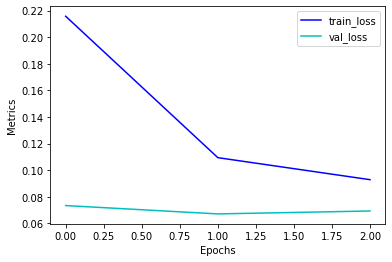

In [15]:
#model.load_state_dict(torch.load((model_path)))
trainer.train(train_dataset, dev_dataset, HParam.n_iter)

In [22]:
torch.save(trainer.model.state_dict(), model_path)
torch.save(trainer.model.word_embedding, embedding_layer_path)

# Predict the test set

In [17]:
#Encode tokens and labels
test_sentences_enc = encode_sentences(test_sentences, sentences_vocabulary)
test_labels_enc = encode_labels(test_labels, labels_vocabulary)

#Create a vocabulary from number to labels
labels_reverse_vocabulary = create_labels_reverse_vocabulary()

#Predict all the sentences
sentences_pred = predict_labels(test_sentences_enc,model,labels_reverse_vocabulary)

### Compute the confusion matrix as heatmap and F1 score of test set

In [18]:
# Flatten the predicted sentences to compute f1_score and confusion matrix
pred_list = [label for sentence in sentences_pred for label in sentence]
true_list = [label for sentence in test_labels for label in sentence]

0.910072979440641


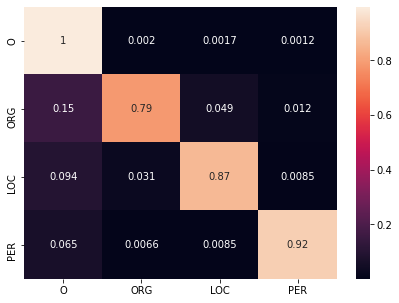

In [19]:
array = confusion_matrix(true_list, pred_list, labels=["O", "ORG", "LOC", "PER"], normalize='true')
df_cm = pd.DataFrame(array, index = ["O", "ORG", "LOC", "PER"],
                  columns = ["O", "ORG", "LOC", "PER"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)

print (f1_score(true_list, pred_list, average='macro'))